# HW 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1

In [2]:
# Read the CSV file
df = pd.read_csv('data_ex1_wt.csv')

### Problem 1

Draw a scatter plot and verify that there is a trend in the data.

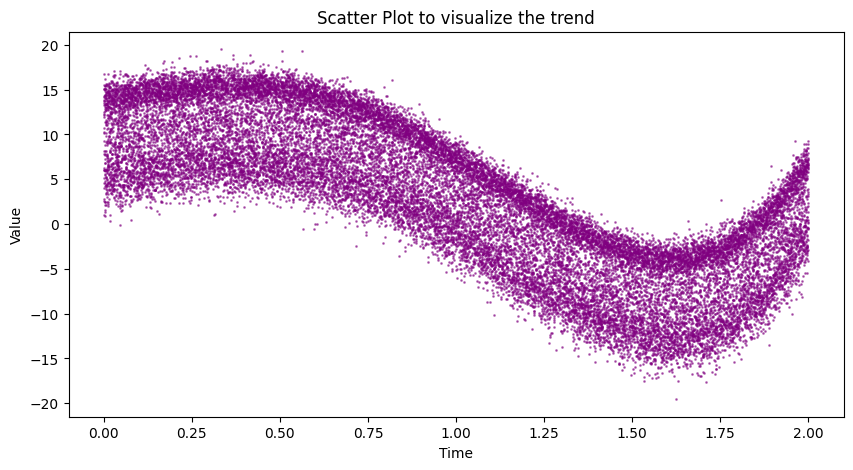

In [14]:
# Display the time series data with a scatter plot

plt.figure(figsize=(10, 5))
plt.scatter(df["time"], df["value"], color="purple", alpha=0.5, s=1)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Scatter Plot to visualize the trend")
plt.show()

### Problem 2

Use least squares to estimate the coefficient of a polynomial trend function, and remove the trend.

In [ ]:
MAX_DEGREE = 10

# Compute the coefficients of polynomial regression from 1 to MAX_DEGREE and plot the results